In [1]:
from matplotlib import pyplot as plt
plt.rcParams['font.size'] = 20
from matplotlib import cm as cmx
import matplotlib.colors as colors
import numpy as np
import pickle
import glob

def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def concatenate_different_sigma(small, large, newd):
    """
    concatenate dict for same element but different sigma
    """
    base = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/'
    dict_small = load_obj(base+small)
    dict_large = load_obj(base+large)
    merged_dict = {**dict_small, **dict_large}

    save_obj(merged_dict, base+newd)

### Learning curves with aslatm

In [2]:
all_alchpots = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_sigma_all.txt')

alchpots_H = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_sigma_H.txt')
alchpots_C = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_sigma_C.txt')
alchpots_N = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_sigma_N.txt')
alchpots_O = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_sigma_O.txt')



In [3]:
datasets = [all_alchpots, alchpots_H, alchpots_C, alchpots_N, alchpots_O]
labels = [r'all $\mu$', r'$\mu_{\rm{H}}$', r'$\mu_{\rm{C}}$', r'$\mu_{\rm{N}}$', r'$\mu_{\rm{O}}$']

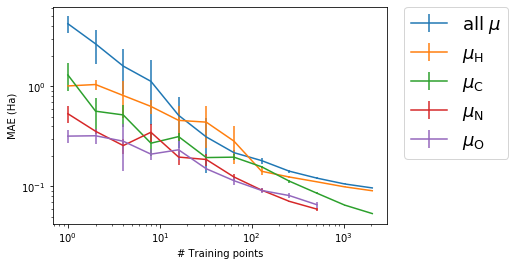

In [4]:
fig, ax = plt.subplots(1,1)
# plt.rcParams.update({'errorbar.capsize': 0})
plt.rcParams.update({'font.size': 18})

for d,l in zip(datasets, labels):
    ax.errorbar(d[:,0], d[:,1], d[:,2], label=l)

ax.set_xlabel('# Training points')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Compare learning for different regularizer

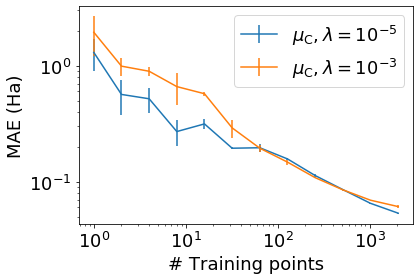

In [27]:
alchpots_C = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_sigma_C.txt')
alchpots_C_largelam = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_sigma_large_lambda_C.txt')

fig, ax = plt.subplots(1,1)

ax.errorbar(alchpots_C[:,0], alchpots_C[:,1], alchpots_C[:,2], label=r'$\mu_{\rm{C}}, \lambda = 10^{-5}$')
ax.errorbar(alchpots_C_largelam[:,0], alchpots_C_largelam[:,1], alchpots_C_largelam[:,2], label=r'$\mu_{\rm{C}}, \lambda = 10^{-3}$')
ax.set_xlabel('# Training points')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Sigma optimization

In [ ]:
# all_alchpot_dict = load_obj('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/all_sigma_all_alchpots.txt')

alchpot_dict = load_obj('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/all_sigma_H')

In [ ]:
plot_dict = alchpot_dict

In [ ]:
plot_dict

In [ ]:
NUM_COLORS = len(plot_dict.keys())
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = [6.0, 4.0]
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for k in plot_dict.keys():
    ax.plot(plot_dict[k][:,0], plot_dict[k][:,1], '-o', label=r'$\sigma = {}$'.format(np.round( float(k.split('_')[1]), 2 )) )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Learning curves for alchemical potential

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def get_aslatm(data, molecule_size):
    # 1) get many body types
    nuclear_charges = []
    for d in data:
        nuclear_charges.append(d[:,0])
    mbtypes = qml.representations.get_slatm_mbtypes(nuclear_charges)
    
    # 2) generate reps for molecules
    reps = []
    for d in data:
        reps.append(qml.representations.generate_slatm(d[:,1:4], d[:,0], mbtypes, local=True))
        
    # 3) convert into pure numpy array with dim N, M: where N number of atoms in data set and M length of representation
    full_reps = np.empty((molecule_size.sum(),len(reps[0][0])))
    j = 0
    for r, l in zip(reps, molecule_size):
        full_reps[j:j+l] = r
        j += l
    
    return(full_reps)

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

all_local_reps = get_aslatm(data)

In [ ]:
# learn alch pot

In [ ]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 11, 12, base=2).astype(int)

for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(all_local_reps, alch_pots, tr_size, sigma, lam_val, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
lcurves

In [ ]:
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]
path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_all_alchpots_small_sigmas.txt'
sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

In [ ]:
# save dictionary of learning curves at all sigmas
fname = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/all_sigma_all_alchpots_small_sigmas.txt'
save_obj(lcurves, fname)

### Learning curves for alchemical potential of single elements

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def get_aslatm(data, molecule_size):
    # 1) get many body types
    nuclear_charges = []
    for d in data:
        nuclear_charges.append(d[:,0])
    mbtypes = qml.representations.get_slatm_mbtypes(nuclear_charges)
    
    # 2) generate reps for molecules
    reps = []
    for d in data:
        reps.append(qml.representations.generate_slatm(d[:,1:4], d[:,0], mbtypes, local=True))
        
    # 3) convert into pure numpy array with dim N, M: where N number of atoms in data set and M length of representation
    full_reps = np.empty((molecule_size.sum(),len(reps[0][0])))
    j = 0
    for r, l in zip(reps, molecule_size):
        full_reps[j:j+l] = r
        j += l
    
    return(full_reps)

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def get_tr_size(data_size):
    """
    largest number of training points is roughly 90% of complete data (largest multiple of 2 that is <= 90%)
    """
    largest_set = int(np.log2(data_size*0.9))
    tr_size = np.logspace(0, largest_set, largest_set+1, base=2).astype(int)
    return(tr_size)

def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    else:
        raise ValueError('Symbol for given charge not available')

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

all_local_reps = get_aslatm(data, molecule_size)

In [ ]:
# split up alchemical potential by element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

el_reps =dict()
el_alch_pots = dict()
for k in idc_by_charge.keys():
    el_reps[k] = all_local_reps[idc_by_charge[k]]
    el_alch_pots[k] = alch_pots[idc_by_charge[k]]

In [ ]:
sigmas = np.logspace(-6, 10, 11, base=2)#np.logspace(-1, 10, 11, base=2) # np.logspace(-6, -2, 5, base=2)
lam_val = 1e-3
num_cv = 3

for charge in el_reps.keys():
    lcurves = dict()

    # define number of training points for which MAE is calculated
    set_sizes = get_tr_size(len(el_alch_pots[charge]))
    
    # special for H
#     set_sizes = np.concatenate((set_sizes, np.array([3300])))

    for sigma in sigmas:
        error_cv = []
        error_std = []
        # calculate error for every training point size
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate(el_reps[charge], el_alch_pots[charge], tr_size, sigma, lam_val, num_cv)
            error_cv.append(err)
            error_std.append(err_std)

        lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T
        
    
    # save best learning curve
    lowest_error = (None, None)
    for k in lcurves.keys():
        if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
            lowest_error = (k, np.amin(lcurves[k][:,1]))
    save_data = lcurves[lowest_error[0]]

    # filename
    el_symbol = get_element_symbol(charge)
    path = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/best_alchpots_large_lambda_sigma_{el_symbol}.txt'

    sig_val = lowest_error[0].split('_')[1]
    header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
    np.savetxt(path, save_data, delimiter='\t', header=header)

    # save dictionary of learning curves at all sigmas
    fname = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/aslatm/large_lambda_all_sigma_alchpots_{el_symbol}.txt'
    save_obj(lcurves, fname)

### Test

In [ ]:
# test if conversion from list of np-arrays to np-array was carried out correctly
a = 0
for j in range(len(reps)):
    for i in range(molecule_size[j]):
        a += (reps[j][i] - full_reps[molecule_size[0:j].sum()+i]).sum()
print(a)
print(len(reps[0])+len(reps[1])+len(reps[2]))
print((reps[3][2] - full_reps[56]).sum())

calculate learning curves for NMR shifts from aSLATM and compare to results in Bing's Amon paper
https://github.com/binghuang2018/aqml-data/tree/master/qm9-3mols/03

In [12]:
import glob
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def get_aslatm(data, molecule_size):
    # 1) get many body types
    nuclear_charges = []
    for d in data:
        nuclear_charges.append(d[:,0])
    mbtypes = qml.representations.get_slatm_mbtypes(nuclear_charges)
    
    # 2) generate reps for atoms
    reps = []
    for d in data:
        reps.append(qml.representations.generate_slatm(d[:,1:4], d[:,0], mbtypes, local=True))
        
    # 3) convert into pure numpy array with dim N, M: where N number of atoms in data set and M length of representation
    full_reps = np.empty((molecule_size.sum(),len(reps[0][0])))
    j = 0
    for r, l in zip(reps, molecule_size):
        full_reps[j:j+l] = r
        j += l
    
    return(full_reps)

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def get_tr_size(data_size):
    """
    largest number of training points is roughly 90% of complete data (largest multiple of 2 that is <= 90%)
    """
    largest_set = int(np.log2(data_size*0.9))
    tr_size = np.logspace(0, largest_set, largest_set+1, base=2).astype(int)
    return(tr_size)

def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    else:
        raise ValueError('Symbol for given charge not available')
        
def parse_file(lines):
    # remove \n
    for idx, l in enumerate(lines):
        lines[idx] = l.strip('\n')
    
    xyz_data = np.empty((len(lines), 6))
    
    for idx, l in enumerate(lines):
        tmp = l.split()
        if tmp[0] == 'H':
            tmp[0] = 1.0
        elif tmp[0] == 'C':
            tmp[0] = 6.0
        elif tmp[0] == 'N':
            tmp[0] = 7.0
        elif tmp[0] == 'O':
            tmp[0] = 8.0
        for i, j in enumerate(tmp):
            tmp[i] = float(j)
        xyz_data[idx] = tmp
            
    
    return(xyz_data)

def split_tr_test(data_in, idx=19):
    return(data_in[:-19], data_in[-19:])

In [13]:
# download xyz-files
# change element symbol to charge number
# make data list of similar shape as alchemy data
# generate learning curves, compare to Bing's results

In [14]:
# parse data from Bing, make data list of similar shape as alchemy data
aqml_path = '/home/misa/git_repositories/aqml-data/qm9-3mols/03/g7/'
aqml_files = glob.glob(aqml_path+'*')

path_target = '/home/misa/git_repositories/aqml-data/qm9-3mols/03/target/03.xyz'
aqml_files.append(path_target)

files = []
for path in aqml_files:
    with open(path, 'r') as fs:
        files.append(fs.readlines()[2:])

data = []
for f in files:
    data.append(parse_file(f))
    
molecule_size = []
for d in data:
    molecule_size.append(d.shape[0])
molecule_size = np.array(molecule_size)

In [15]:
all_local_reps = get_aslatm(data, molecule_size)
nmr_shifts = []
for d in data:
    nmr_shifts.extend(d[:, 5])
nmr_shifts = np.array(nmr_shifts)

charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

In [16]:
# split training and test
reps_tr, reps_test = split_tr_test(all_local_reps)
nmr_shifts_tr, nmr_shifts_test = split_tr_test(nmr_shifts)
charges_tr, charges_test = split_tr_test(charges)
idc_by_charge_tr = qmi.partition_idx_by_charge(charges_tr)
idc_by_charge_test = qmi.partition_idx_by_charge(charges_test)

In [17]:
# split reps, labels bz element
el_reps_tr =dict()
el_nmr_tr = dict()
for k in idc_by_charge_tr.keys():
    el_reps_tr[k] = reps_tr[idc_by_charge_tr[k]]
    el_nmr_tr[k] = nmr_shifts_tr[idc_by_charge_tr[k]]

el_reps_test =dict()
el_nmr_test = dict()
for k in idc_by_charge_test.keys():
    el_reps_test[k] = reps_test[idc_by_charge_test[k]]
    el_nmr_test[k] = nmr_shifts_test[idc_by_charge_test[k]]

In [18]:
# find best sigma
distances = []
for r in range(len(all_local_reps)):
    for j in range(r+1, len(all_local_reps)):
        distances.append(np.linalg.norm(all_local_reps[r]-all_local_reps[j]))
distances = np.array(distances)

sigma_opt = np.amax(distances)/np.sqrt(2*np.log(2))

In [19]:
sigma_opt

9.541198699239287

In [20]:
lam_val = 1e-8

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 8, 9, base=2).astype(int)

# calculate error for every training point size
for k in el_reps_tr.keys():
    coeffs = qmi.train_kernel(el_reps_tr[k], el_nmr_tr[k], sigma_opt, lam_val)
    labels_predicted = qmi.predict_labels(el_reps_test[k], el_reps_tr[k], sigma_opt, coeffs)
    err = (np.abs(labels_predicted - el_nmr_test[k])).mean()
    err_std = (np.abs(labels_predicted - el_nmr_test[k])).std()
    lcurves[k] = [err, err_std]

In [21]:
len(el_reps_tr[6.0])

106

In [22]:
lcurves

{1.0: [0.0016533259699176902, 0.0013544154735222699],
 6.0: [0.012321129405275756, 0.013389753563229337],
 8.0: [0.005038414580002176, 0.001827056789045045]}